# **DL-Advanced Model: Transfer Learning**

<ins>Group Members</ins>: Catrina Hacker, Yoonduk Kim, Mohit Bagri

This notebook contains the code for one of our advanced deep learning models. This model uses transfer learning by starting with a pretrained version of AlexNet and then training for an additional 10 epochs to do ternary classification of images to assign labels of: 

*   0: no mask
*   1: correctly worn mask
*   2: incorrectly worn mask

In addition to transfer learning, our advanced model also adds data augmentaiton to our baseline model approach. 

#**Imports**#

In [ ]:
import pandas as pd
import os
import numpy as np
import joblib
# from tqdm import tqdm

import torch
import random
import albumentations
import matplotlib.pyplot as plt
import argparse
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from PIL import Image
from tqdm import tqdm
from torchvision import models as models
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import seaborn as sns

import tqdm
from IPython import display

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**Image Set Up**

In [ ]:
# Directories for Catrina's computer
labels_dir = '/content/drive/My Drive/Colab Notebooks/CIS522- Deep Learning/Final Project/data/input/lb.pkl'
img_dir = '/content/drive/My Drive/Colab Notebooks/CIS522- Deep Learning/Final Project/data/img/'
data_path = '/content/drive/My Drive/Colab Notebooks/CIS522- Deep Learning/Final Project/data/input/data.csv'

lb = joblib.load(labels_dir)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [ ]:
def seed_everything(SEED=1337):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True

In [ ]:
def norm_mean_std(X, img_size):
    images = []

    img_means = []
    img_stds = []

    resize = albumentations.Compose(
        [albumentations.Resize(img_size, img_size, always_apply=True)]
    )

    for i, img_path in tqdm(enumerate(X), total=len(X)):
        image = Image.open(img_path)
        image = image.convert("RGB")
        image = resize(image=np.array(image))

        images.append(image["image"])

    img_np = np.stack(images, axis=0)

    print(img_np.shape)
    # (10000, 256, 256, 3)

    for i in range(3):
        img_means.append(np.mean(img_np[:, :, :, i]))
        img_stds.append(np.std(img_np[:, :, :, i]))

    # divide means and stds by 255
    img_means = np.asarray(img_means) / 255
    print(img_means)

    img_stds = np.asarray(img_stds) / 255
    print(img_stds)

    return img_means, img_stds


In [ ]:
# image dataset module
class ImageDataset(Dataset):
    def __init__(self, path, labels, img_size, train=True):
        # precomputed values for image normalization
        self.img_means = [0.5243259, 0.47015686, 0.45026454]
        self.img_stds = [0.29682344, 0.28559578, 0.28816244]

        self.X = path
        self.y = labels
        # apply augmentations
        if train:
          self.aug = albumentations.Compose(
              [
                  albumentations.Resize(img_size, img_size, always_apply=True),
                  albumentations.HorizontalFlip(p=1.0),
                  albumentations.ShiftScaleRotate(
                      shift_limit=0.3, scale_limit=0.3, rotate_limit=30, p=1.0
                  ),
                  albumentations.Normalize(
                      mean=self.img_means, std=self.img_stds, always_apply=True
                  ),
              ]
          )
        else:
          self.aug = albumentations.Compose(
              [
                  albumentations.Resize(img_size, img_size, always_apply=True),
                  albumentations.Normalize(
                      mean=self.img_means, std=self.img_stds, always_apply=True
                  ),
              ]
          )

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        image = Image.open(self.X[i])
        image = image.convert("RGB")
        image = self.aug(image=np.array(image))["image"]
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        label = self.y[i]
        return (
            torch.tensor(image, dtype=torch.float),
            torch.tensor(label, dtype=torch.long),
        )

In [ ]:
# set variables
SEED = 1337
seed_everything(SEED=SEED)
img_size = 256
test_size = 0.2
batch_size = 4

# set computation device
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Computation device: {device}")

# read the data.csv file and get the image paths and labels
df = pd.read_csv(data_path)

X = df.image_path.values
y = df.target.values

X_orig = df.image_path.values
for i in range(0, X_orig.shape[0]):
  X[i] = img_dir + X_orig[i][12:]
y = df.target.values

(xtrain, xtest, ytrain, ytest) = train_test_split(
    X, y, test_size=test_size, random_state=SEED
)

train_data = ImageDataset(xtrain, ytrain, img_size=img_size, train=True)
test_data = ImageDataset(xtest, ytest, img_size=img_size, train=False)

trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

Computation device: cuda:0


#**AlexNet Implementation**

##Train

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


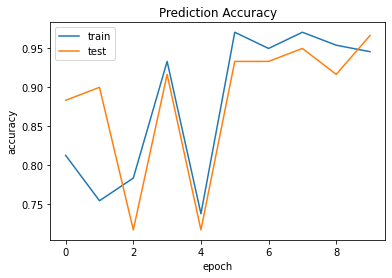

In [ ]:
alexnet = torch.hub.load('pytorch/vision:v0.9.0', 'alexnet', pretrained=True).to(device)
optimizer = optim.Adam(alexnet.parameters(), lr=1e-4)
loss_fn = torch.nn.CrossEntropyLoss()

test_accuracies = []
train_accuracies = []
for epoch in range(10):

    # Train loop
    alexnet.train()
    for batch in tqdm.notebook.tqdm(trainloader):
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        output = alexnet(images)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()

    # Eval loop
    alexnet.eval()
    train_total_correct = 0
    for batch in tqdm.notebook.tqdm(trainloader):
        image, labels = batch
        image = image.to(device)
        labels = labels.to(device)
        
        output = alexnet(image)
        train_predictions = torch.argmax(output, dim=1)
        train_num_correct = torch.sum(train_predictions == labels)
        train_total_correct += train_num_correct

    test_total_correct = 0
    for batch in tqdm.notebook.tqdm(testloader):
        image, labels = batch
        image = image.to(device)
        labels = labels.to(device)
        
        output = alexnet(image)
        test_predictions = torch.argmax(output, dim=1)
        test_num_correct = torch.sum(test_predictions == labels)
        test_total_correct += test_num_correct

    # Visualize accuracy
    test_accuracy = test_total_correct / len(test_data)
    test_accuracies.append(test_accuracy.item()) 
    train_accuracy = train_total_correct / len(train_data)
    train_accuracies.append(train_accuracy.item())

plt.plot(train_accuracies, label='train')
plt.plot(test_accuracies, label='test')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Prediction Accuracy')
plt.legend()
plt.show()
    # display.clear_output(wait=True)
    # display.display(plt.gcf())

##Test

In [ ]:
def confusion_matrix(preds, labels):
  # Produces a confusion matrix for the output of a test batch
  # Args:
    # preds (tensor): predictions from model output
    # labels (tensor): ground-truth labels
  # Returns: 
    # None

  # Generate values for confusion matrix
  nomask = np.zeros((1, 3))
  correct = np.zeros((1, 3))
  incorrect = np.zeros((1, 3))
  cnt = 0
  for prediction, label in zip(preds, labels):
    prediction = int(prediction)
    label = int(label)
    if label == 0: # no mask
      nomask[0, prediction] += 1 
    elif label == 1: # correctly worn
      correct[0, prediction] += 1
    elif label == 2: # incorrectly worn
      incorrect[0, prediction] += 1
  
  confusion_matrix = np.concatenate((nomask/np.sum(nomask), correct/np.sum(correct), incorrect/np.sum(incorrect)))
  confusion_matrix = confusion_matrix
  print(confusion_matrix)

  # Plot
  sns.heatmap(confusion_matrix, annot=True, fmt='.2f')
  plt.ylabel('label')
  plt.xlabel('prediction')
  plt.xticks([0.5, 1.5, 2.5], ['no mask', 'correct', 'incorrect'])
  plt.yticks([0.5, 1.5, 2.5], ['no mask', 'correct', 'incorrect'], verticalalignment='center')

In [ ]:
def f1_score(labels, preds): 
  # From https://gist.github.com/SuperShinyEyes/dcc68a08ff8b615442e3bc6a9b55a354
  tp = (labels * preds).sum().to(torch.float32)
  tn = ((1 - labels) * (1 - preds)).sum().to(torch.float32)
  fp = ((1 - labels) * preds).sum().to(torch.float32)
  fn = (labels * (1 - preds)).sum().to(torch.float32)

  epsilon = 1e-7

  precision = tp / (tp + fp + epsilon)
  recall = tp / (tp + fn + epsilon)

  f1 = 2* (precision*recall) / (precision + recall + epsilon)

  print('F1 score is %.2f' % f1)

In [ ]:
alexnet.eval()
total_correct = 0
all_preds = torch.empty((0)).to(device)
all_labels = torch.empty((0)).to(device)
for batch in tqdm.notebook.tqdm(testloader):
    image, labels = batch
    image = image.to(device)
    labels = labels.to(device)
    
    output = alexnet(image)
    predictions = torch.argmax(output, dim=1)

    all_preds = torch.cat((all_preds, predictions), dim=0)
    all_labels = torch.cat((all_labels, labels), dim=0)
    num_correct = torch.sum(predictions == labels)
    total_correct += num_correct

Test accuracy: 96.67%
F1 score is 1.53
[[1.         0.         0.        ]
 [0.         1.         0.        ]
 [0.11764706 0.         0.88235294]]


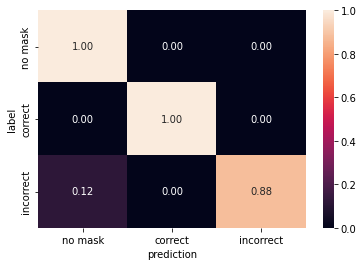

In [ ]:
print('Test accuracy: %.2f%%' % (total_correct * 100/len(all_labels)))

f1_score(all_labels, all_preds)

confusion_matrix(all_preds.cpu().numpy(), all_labels.cpu().numpy())

In [ ]:
from sklearn.metrics import f1_score

print(f1_score(all_labels.cpu().numpy(), all_preds.cpu().numpy(), average='micro'))

0.9666666666666667
